In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
import tqdm
import scipy.optimize
import healpy as hp
# sys.path.append('/home/zhuoqizhang/miniconda3/envs/shearDM/lib/python3.10/site-packages/')
import pymaster as nmt
import os
nside = 1024
npix = hp.nside2npix(nside)

In [2]:
def get_Mask(label):
    
    with h5py.File('metacal_gold_combined_20230613.hdf', 'r') as f:

        ra      = np.array(f['RA'])
        dec     = np.array(f['DEC'])
        e1, e2  = np.array(f[f'mcal_g_{label}']).T

        mag_r   = 30 - 2.5*np.log10(np.array(f[f'mcal_flux_{label}'])[:, 0])
        mag_i   = 30 - 2.5*np.log10(np.array(f[f'mcal_flux_{label}'])[:, 1])
        mag_z   = 30 - 2.5*np.log10(np.array(f[f'mcal_flux_{label}'])[:, 2])

        SNR     = np.array(f[f'mcal_s2n_{label}'])
        T_ratio = np.array(f[f'mcal_T_ratio_{label}'])
        T       = np.array(f[f'mcal_T_{label}'])
        flags   = np.array(f['mcal_flags'])

        GOLD_Foreground  = hp.read_map('Gold_Foreground_20230607.fits', dtype = int)
        FLAGS_Foreground = GOLD_Foreground[hp.ang2pix(hp.npix2nside(GOLD_Foreground.size), ra, dec, lonlat = True)]

        #Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)

        SNR_Mask   = (SNR > 10) & (SNR < 1000)
        Tratio_Mask= T_ratio > 0.5
        T_Mask     = T < 10
        Flag_Mask  = flags == 0
        Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (e1**2 + e2**2 > 0.8**2))
        GOLD_Mask  = FLAGS_Foreground == 0 #From gold catalog
        SG_Mask    = np.array(f['sg_bdf']) >= 4 #Star-galaxy separator
        Color_Mask = ((18 < mag_i) & (mag_i < 23.5) & 
                      (15 < mag_r) & (mag_r < 26) & 
                      (15 < mag_z) & (mag_z < 26) & 
                      (-1.5 < mag_r - mag_i) & (mag_r - mag_i < 4) & 
                      (-1.5 < mag_i - mag_z) & (mag_i - mag_z < 4)
                     )

        print(np.sum(SNR_Mask), np.sum(Tratio_Mask), np.sum(T_Mask), np.sum(Flag_Mask), np.sum(Other_Mask))

        Mask = SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Color_Mask & Other_Mask & GOLD_Mask & SG_Mask
        print("TOTAL NUM", np.sum(Mask))

    return Mask

In [3]:
def mean(x, inds): 
    return np.bincount(inds,weights=x)/np.bincount(inds)

In [4]:
Mask0 = get_Mask('noshear')
Mask1p = get_Mask('1p')
Mask1m = get_Mask('1m')
Mask2p = get_Mask('2p')
Mask2m = get_Mask('2m')

/tmp/ipykernel_1031965/2968844268.py:9: RuntimeWarning: invalid value encountered in log10
  mag_r   = 30 - 2.5*np.log10(np.array(f[f'mcal_flux_{label}'])[:, 0])
/tmp/ipykernel_1031965/2968844268.py:10: RuntimeWarning: invalid value encountered in log10
  mag_i   = 30 - 2.5*np.log10(np.array(f[f'mcal_flux_{label}'])[:, 1])
/tmp/ipykernel_1031965/2968844268.py:11: RuntimeWarning: invalid value encountered in log10
  mag_z   = 30 - 2.5*np.log10(np.array(f[f'mcal_flux_{label}'])[:, 2])
/tmp/ipykernel_1031965/2968844268.py:27: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (SNR < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (e1**2 + e2**2 > 0.8**2))


133507096 109339922 242858406 244200019 240073201
TOTAL NUM 45407069
133505959 109354001 242858583 244200019 240073776
TOTAL NUM 45411009
133510194 109337897 242859108 244200019 240074536
TOTAL NUM 45410428
133504928 109346553 242858554 244200019 240070554
TOTAL NUM 45409733
133511024 109343032 242859186 244200019 240073854
TOTAL NUM 45411119


## Vectorized calibration

In [5]:
dgamma = 2*0.01

In [6]:
with h5py.File('metacal_gold_combined_20230613.hdf', 'r') as f:
    bin_edge = np.percentile(f['mcal_s2n_noshear'][Mask0],np.linspace(0,100,21))
    bin_edge[0], bin_edge[-1] = -99999, 99999
    inds0 = np.digitize(f['mcal_s2n_noshear'][Mask0],bin_edge)-1
    inds1p = np.digitize(f['mcal_s2n_1p'][Mask1p],bin_edge)-1
    inds1m = np.digitize(f['mcal_s2n_1m'][Mask1m],bin_edge)-1
    inds2p = np.digitize(f['mcal_s2n_2p'][Mask2p],bin_edge)-1
    inds2m = np.digitize(f['mcal_s2n_2m'][Mask2m],bin_edge)-1
    
    R11 = (mean(f['mcal_g_1p'][:,0][Mask0],inds0) - mean(f['mcal_g_1m'][:,0][Mask0],inds0))/dgamma
    R11s = (mean(f['mcal_g_noshear'][:,0][Mask1p],inds1p) - mean(f['mcal_g_noshear'][:,0][Mask1m],inds1m))/dgamma
    R11tot = R11+R11s
    
    R22 = (mean(f['mcal_g_2p'][:,1][Mask0],inds0) - mean(f['mcal_g_2m'][:,1][Mask0],inds0))/dgamma
    R22s = (mean(f['mcal_g_noshear'][:,1][Mask2p],inds2p) - mean(f['mcal_g_noshear'][:,1][Mask2m],inds2m))/dgamma
    R22tot = R22+R22s
    
    e1 = mean(f['mcal_g_noshear'][:,0][Mask0],inds0)/R11tot
    e2 = mean(f['mcal_g_noshear'][:,1][Mask0],inds0)/R22tot
    
    e1_err = np.sqrt(mean((f['mcal_g_noshear'][:,0][Mask0]/R11tot[inds0]-e1[inds0])**2,inds0)/np.bincount(inds0))
    e2_err = np.sqrt(mean((f['mcal_g_noshear'][:,1][Mask0]/R22tot[inds0]-e2[inds0])**2,inds0)/np.bincount(inds0))
    
    bin_center = mean(f['mcal_s2n_noshear'][Mask0],inds0)

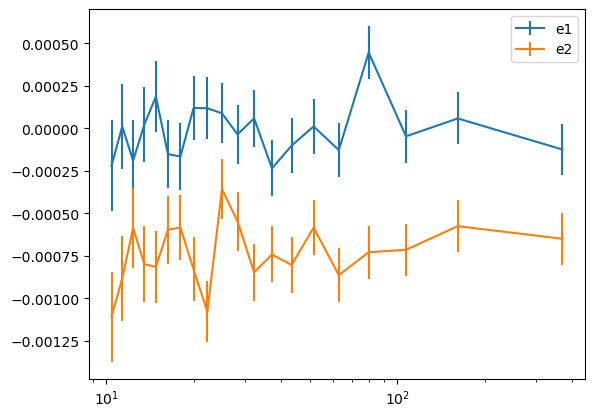

In [11]:
plt.errorbar(bin_center,e1,yerr=e1_err,label='e1')
plt.errorbar(bin_center,e2,yerr=e2_err,label='e2')
plt.xscale('log')
plt.legend()

## Calibration per bin

In [8]:
def get_Rs(cat, m0, m_1p, m_1m, m_2p, m_2m):
    
    # calcualte metacalibration factors
    dgamma = 2*0.01
    
    R11  = (np.mean(cat['mcal_g_1p'][:,0][m0]) - np.mean(cat['mcal_g_1m'][:,0][m0]))/dgamma
    R11s = (np.mean(cat['mcal_g_noshear'][:,0][m_1p]) - np.mean(cat['mcal_g_noshear'][:,0][m_1m]))/dgamma
    R11tot = R11 + R11s

    R22  = (np.mean(cat['mcal_g_2p'][:,1][m0]) - np.mean(cat['mcal_g_2m'][:,1][m0]))/dgamma
    R22s = (np.mean(cat['mcal_g_noshear'][:,1][m_2p]) - np.mean(cat['mcal_g_noshear'][:,1][m_2m]))/dgamma
    R22tot = R22 + R22s
    
    return R11tot, R22tot

In [9]:
def calibrate_bin_X(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = Mask0.copy(), Mask1p.copy(), Mask1m.copy(), Mask2p.copy(), Mask2m.copy()
    
    mask0 = df0*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1p = df_1p*(cat[tag+'_1p'][:]>lim1)*(cat[tag+'_1p'][:]<=lim2)
    mask_1m = df_1m*(cat[tag+'_1m'][:]>lim1)*(cat[tag+'_1m'][:]<=lim2)
    mask_2p = df_2p*(cat[tag+'_2p'][:]>lim1)*(cat[tag+'_2p'][:]<=lim2)
    mask_2m = df_2m*(cat[tag+'_2m'][:]>lim1)*(cat[tag+'_2m'][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2)

In [12]:
XX = []
with h5py.File('metacal_gold_combined_20230613.hdf', 'r') as f:
    for i in tqdm.trange(20):
        snr1 = bin_edge[i]
        snr2 = bin_edge[i+1]
        X = calibrate_bin_X(f, 'mcal_s2n', snr1, snr2)
        XX.append(X)
    XX = np.array(XX)

100%|██████████| 20/20 [11:18<00:00, 33.90s/it]


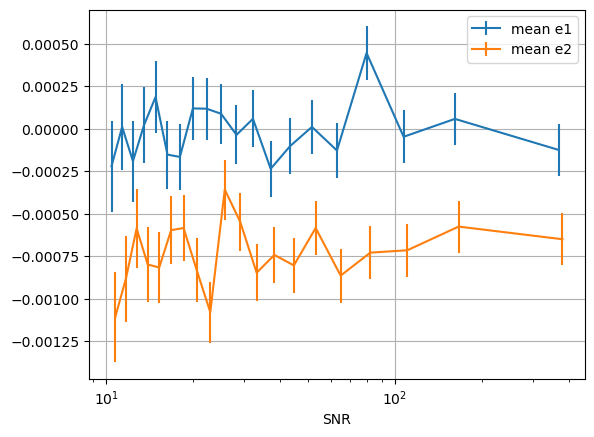

In [14]:
plt.errorbar(bin_center, XX[:,0], XX[:,2], label='mean e1')
plt.errorbar(bin_center*1.03, XX[:,1], XX[:,3], label='mean e2')

plt.xscale('log')
plt.xlabel('SNR')
plt.legend()
plt.grid()